In [2]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, relu_
localConv2D = torch.nn.backends.thnn.backend.SpatialConvolutionLocal
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from sklearn.linear_model import LinearRegression

from utils import *

import warnings
warnings.filterwarnings('ignore')

In [8]:
A = torch.ones(2, 2, requires_grad=True) + 2.
x = torch.ones(2, 2, requires_grad=True)
y = x*2
print(y)

tensor([[ 2.,  2.],
        [ 2.,  2.]])


In [9]:
y.sum().backward()

In [10]:
x.grad

tensor([[ 2.,  2.],
        [ 2.,  2.]])

In [2]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.012

def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.00
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)


In [3]:
class GCN2DWithExcitation(object):
    def __init__(self,
                 numX,
                 numY,
                 inhibitionWindow,
                 inhibitionRadius,                 
                 inhibitionStrength,
                 boostEffect=10,
                 boostDecay=0.2,
                 dt=0.001,
                 numPlaces=200,
                 globalTonic=20,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactor=.9,
                 initialWeightFactor=.2,
                 weightDecay=60,
                 boostGradientX=0,
                 wideningFactor=0,
                 excitationMode="Square",
                ):
        self.activity = torch.zeros([1., 1., numX, numY], device=device, dtype=torch.float)
        self.filter = torch.zeros([1, 1, 1+2*inhibitionWindow, 1+2*inhibitionWindow], dtype=torch.float,
                                 device=device)
        
        weight=Variable(torch.randn(numX,numY,1,1+2*inhibitionWindow,1+2*inhibitionWindow)) # outH x outW x outC x inC x kH x kW
        self.bias=torch.zeros(1,numX,numY) # outC x outH x outW

        ## arguments: kH, kW, strideH, strideW, padH, padW, inH, inW, outH, outW
        self.localConvolution=localConv2d(1+2*inhibitionWindow, 1+2*inhibitionWindow,
                                     1, 1, inhibitionWindow, inhibitionWindow,,
                                     numX, numY, numX, numY)
        
        outputs=local(inputs, weight, bias) # N x outC x outH x outW

        
        self.numX = numX
        self.numY = numY
        self.numPlaces=numPlaces
        
        for i in range(1+2*inhibitionWindow):
            for j in range(1+2*inhibitionWindow):
                xComp = np.abs(i - (inhibitionWindow))
                yComp = np.abs(j - (inhibitionWindow))
                dist = np.asarray((xComp, yComp))
                dist = dist[0] ** 2 + dist[1] ** 2
                
                dist = max(dist - wideningFactor, 0)
                
                self.filter[0, 0, i, j] = w_0(dist/inhibitionRadius)*inhibitionStrength
                
        self.activationHistory = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.boostEffect = torch.tensor(np.repeat(
            np.linspace(1, boostGradientX, self.numX)[:, np.newaxis], self.numY, axis=-1)*boostEffect,
                                       device=device, dtype=torch.float)
        self.boostDecay = boostDecay
        self.dt = dt
        self.globalTonic = torch.tensor([globalTonic], device=device, dtype=torch.float)
        self.decay = decayConstant
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = 0.01
        self.learningRate = learningRate
        self.negativeLearnFactor = negativeLearnFactor
        self.weightDecay = weightDecay
        
        self.directions = {"n": torch.tensor(np.array([-1.0, 0.0], device=device, dtype=torch.float)),
                           "e": torch.tensor(np.array([0.0, 1.0], device=device, dtype=torch.float)),
                           "s": torch.tensor(np.array([1.0, 0.0], device=device, dtype=torch.float)),
                           "w": torch.tensor(np.array([0.0, -1.0], device=device, dtype=torch.float))
                           }

        self.activityE = dict((k, torch.zeros([1., 1., numX, numY], device=device, dtype=torch.float))
                                for k in self.directions.iterkeys())
        
        self.instantaneousE = dict((k, torch.zeros([1., 1., numX, numY], device=device, dtype=torch.float))
                                for k in self.directions.iterkeys())
        
        
        self.historyE = dict((k, torch.zeros([1., 1., numX, numY], device=device, dtype=torch.float))
                                for k in self.directions.iterkeys())
        
        
        self.weightsEI = dict((k, torch.zeros([numX*numY, numX*numY])) for k in self.directions.iterkeys())
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.random.rand(numPlaces, 2), device=device, dtype=torch.float)
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numY, numPlaces)*initialWeightFactor,
                                         device=device, dtype=torch.float)
        
        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """
        envelopeX = [1 if np.abs(p) < 1 - self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((np.abs(p) - 1 + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.linspace(-1, 1, self.numX)]

        envelopeY = [1 if np.abs(p) < 1 - self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((np.abs(p) - 1 + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.linspace(-1, 1, self.numY)]

        return np.outer(envelopeX, envelopeY)
    
    def randomLesions(self, numLesions, lesionRadius):
        lesions = []
        for i in range(numLesions):
            x = int(np.random.rand()*self.numX)
            y = int(np.random.rand()*self.numY)
            lesions.append((x, y))
            
        radii = [lesionRadius] * numLesions
        
        self.addLesions(lesions, radii)
    
    def addLesions(self, lesionCenters, lesionRadii):
        for center, radius in zip(lesionCenters, lesionRadii):
            for x in range(self.numX):
                for y in range(self.numY):
                    if (x - center[0])**2 + (y - center[1])**2 < radius**2:
                        self.envelope[x, y] = 0.


        
    def step(self, speed=1, excitatory=False, velocity=(0,0)):        
        self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX, self.numY)
        self.instantaneous += conv2d(self.activity, self.filter, padding=self.inhibitionWindow)
        
        # Excitatory connections should usually be left off during learning for speed.
        if excitatory:
            for k, inst in self.instantaneousE.items():
                inst.copy_(self.instantaneous)
                inst += conv2d(self.activity, self.filter, padding=self.inhibitionWindow)
                inst += self.globalTonic
                inst += self.historyE[k] * self.boostEffect
                inst *= self.envelope
                inst *= torch.dot(self.directions[k], velocity)
                
                self.instantaneous += torch.matmul(self.weightsEI[k],
                                                   self.activityE[k].view(self.numX,
                                                                          self.numY)).view(1, 1,
                                                                                           self.numX, self.numY)
                
        self.instantaneous += self.globalTonic
        self.instantaneous += self.activationHistory * self.boostEffect
        

        self.instantaneous *= self.envelope
        self.instantaneous *= max(speed, 1)
        relu_(self.instantaneous)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        self.activationHistory += (torch.sum(self.activity)/torch.sum(self.envelope) - self.activity)*self.envelope
        self.activationHistory *= max(speed, 1) - self.boostDecay
        
        
    def simulate(self, time, logFreq = 10, startFrom = 0):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY), device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX, self.numY], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step()
            if t % logFreq == 0 and t*self.dt > startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX, self.numY))
                s += 1
                
        return output.cpu().numpy()
    
    def decayWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*self.placeWeights/self.weightDecay
    
    def learn(self, time, plotting=True, plotInterval=100):
        if plotting:
                fig, (ax1, ax2, ax3) = plt.subplots(3,1)
                ax1.scatter(self.places[:, 0].cpu().numpy(),
                    self.places[:, 1].cpu().numpy(),
                    c = self.placeActivity.cpu().numpy(),
                    cmap = plt.get_cmap("coolwarm"))
                ax2.matshow(self.activity.view((self.numX, self.numY)).cpu().numpy())
                im = ax3.scatter(self.places[:, 0].cpu().numpy(),
                            self.places[:, 1].cpu().numpy(),
                            c = self.placeWeights[self.numX//2, self.numY//2, :].cpu().numpy(),
                            cmap = plt.get_cmap("coolwarm"))
                fig.colorbar(im, ax=ax3)
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX*self.numY],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.learningRate
        self.bufferIndex = 0
        
        times = np.arange(0, time, self.dt)
        trajectory = np.zeros((len(times), 2))
        trajectory[:, 0] = (np.sin((times * np.pi / (10*1.34754))) + 1)/2
        trajectory[:, 1] = (np.sin((times * np.pi / (10*1.6383478))) + 1)/2
        velocity = np.diff(trajectory, axis=0)
        
        trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
        velocity = torch.tensor(velocity, device=device, dtype=torch.float)
        speed = torch.norm(velocity, 2, dim=-1)
        
        for i, t in enumerate(times[:-1]):
            pos = trajectory[i, :]
            s = speed[i]
            torch.exp(-1.*torch.norm((self.places - pos), 2, dim=-1) \
                      / (2*(self.sigmaLoc)), out=self.placeActivity)
            self.step(speed=s)
            self.stdpUpdate(i)
            torch.max(self.placeWeights, self.zero, out=self.placeWeights)
            torch.min(self.placeWeights, self.zero + 10., out=self.placeWeights)
            self.decayWeights()
            if i % plotInterval == 0:
                if plotting:
                    ax1.scatter(self.places[:, 0].cpu().numpy(),
                        self.places[:, 1].cpu().numpy(),
                        c = self.placeActivity.cpu().numpy(),
                        cmap = plt.get_cmap("coolwarm"))
                    ax2.matshow(self.activity.view((self.numX, self.numY)).cpu().numpy())
                    im = ax3.scatter(self.places[:, 0].cpu().numpy(),
                                self.places[:, 1].cpu().numpy(),
                                c = self.placeWeights[self.numX//2, self.numY//2, :].cpu().numpy(),
                                cmap = plt.get_cmap("coolwarm"))
                    ax1.set_title(str(t))
                    fig.canvas.draw()
                    
                
    def stdpUpdate(self, time, clearBuffer=False):
        if time < self.activityBuffer.shape[0]:
            self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                self.placeWeights += torch.ger(self.activity.view(self.numX*self.numY), self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numY, self.numPlaces)
                self.placeWeights -= (torch.ger(self.activityBuffer[i], self.placeActivity) *\
                                        self.stdpValues[t]).view(self.numX, self.numY, self.numPlaces) *\
                                      self.negativeLearnFactor
                
            self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
            self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            
            
        if clearBuffer:
            pass

In [4]:
GCN = GCN2D(48,
            48,
            12,
            .1,
            500,
            globalTonic=1,
            stdpWindow=1,
            dt=0.01,
            boostEffect=1,
            boostDecay=.01,
            numPlaces=500,
            learningRate=.5,
            initialWeightFactor=10,
            boostGradientX=1,
            weightDecay=2000,
            wideningFactor=2,
            negativeLearnFactor=0)

#GCN.randomLesions(10, 10)

plt.matshow(GCN.filter[0,0])
plt.show()

plt.matshow(GCN.envelope)
plt.show()


plt.matshow(GCN.boostEffect)
plt.show()

plt.figure()
plt.scatter(GCN.places[:, 0].cpu().numpy(),
             GCN.places[:, 1].cpu().numpy())
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


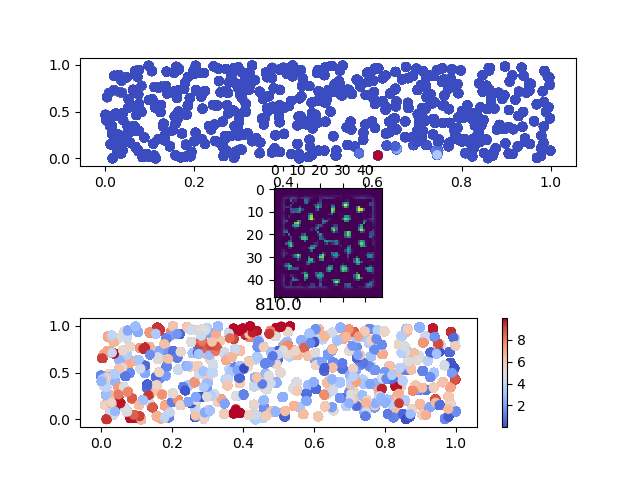

In [ ]:
GCN.learn(5000, plotting=True, plotInterval=1000)

In [ ]:
plt.figure()
plt.scatter(GCN.places[:, 0].cpu().numpy(),
            GCN.places[:, 1].cpu().numpy(),
            c = GCN.placeWeights[25, 24, :].cpu().numpy(),
            cmap = plt.get_cmap("coolwarm"))
plt.colorbar()
plt.draw()


In [ ]:
results = GCN.simulate(10, logFreq=50, startFrom = 0)
plt.matshow(results[-2])
plt.show()

In [ ]:
mask = np.zeros((GCN.numX, GCN.numY))

for i in range(0, GCN.numX, 1):
    for j in range(0, GCN.numY, 1):
        mask[i, j] = 1.

processedResults, flowVelocities, flowColors = get_data_flow_and_color_maps(results[1100:1150], GCN.numX, GCN.numY, mask, 1)
processedResults = processedResults.reshape(-1, GCN.numX, GCN.numY)
flowColors = flowColors.reshape(-1, GCN.numX, GCN.numY, 3)

In [ ]:
def createMovieWithFlow(data, colors, name):
    def update(num, data, a):
        results, flowColors = data
        a[0].set_data(results[num])
        a[1].set_data(flowColors[num])
        return a,

    fig, ax   = plt.subplots(1,2)

    a0  = ax[0].imshow(data[0], animated=True)
    a1  = ax[1].imshow(colors[0], animated=True)

    ani = animation.FuncAnimation(fig, update, data.shape[0] - 1, fargs=((data, colors,), (a0,a1)),
                                   interval=10, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
createMovieWithFlow(processedResults, flowColors,
                      "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\flowtest.mp4")

In [ ]:
def createMovie(data, name, interval=10):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,
    
    fig, ax   = plt.subplots(1,1)

    a0  = ax.imshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, data.shape[0] - 1,
                                  fargs=(data, a0),
                                  interval=interval, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
plt.matshow(GCN.activationHistory.view(GCN.numX, GCN.numY))

In [ ]:
createMovie(results[-100:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", 1)

<video controls src="./test.mp4" />